In [ ]:
# import numpy as np
# import pandas as pd
# from scipy import stats
# from sklearn.metrics import auc  # or numeric integration

# algorithms = ['random', 'spiral', 'boustrophedon', 'proposed']
# episodes = range(1, N_episodes+1)

# # Build a dataframe to hold per-episode metrics
# rows = []
# for ep in episodes:
#     for alg in algorithms:
#         epdata = load_episode(alg, ep)  # implement loader that returns dict
#         dsteps = {eval(k): v for k, v in epdata['dirty_tile_steps'].items()}
#         # replace None with max_steps (or handle as censored)
#         values = [ (v if v is not None else max_steps) for v in dsteps.values() ]
#         ct_avg = np.mean(values)
#         ct_max = np.max(values)
#         # if you saved cumulative cleaned vector: compute AUC
#         Cvec = epdata.get('Cvec', None)
#         if Cvec is not None:
#             ep_auc = np.sum(Cvec)   # discrete AUC
#         else:
#             ep_auc = np.nan
#         rows.append({'episode':ep, 'alg':alg, 'ct_avg':ct_avg, 'ct_max':ct_max, 'auc':ep_auc})
# df = pd.DataFrame(rows)


In [ ]:
# def safe_float(x):
#     return float(x) if x is not None else None

# def compute_episode_metrics(rec, treat_uncleaned_as_steps=True, normalize_auc=False):
#     """
#     Given a single record (dict), compute metrics.
#     Returns dict with:
#       - episode (seed)
#       - steps (S)
#       - n_dirty
#       - ctot_avg (mean first-clean time normalized by steps)
#       - ctot_max (max first-clean time normalized by steps)
#       - ctot_avg_raw (mean first-clean time in steps)
#       - ctot_max_raw (max first-clean time in steps)
#       - C_t (np.array length S+1 where C_t[t] = #dirty cleaned by step t; index 0 = 0)
#       - AUC (sum C_t over t=1..S) optionally normalized by (n_dirty * S)
#       - reward / movement_cost if present
#       - censored_count (# dirty tiles never cleaned)
#     """
#     S = int(rec.get("steps"))
#     episode = rec.get("episode", rec.get("seed", None))
#     dirty = rec.get("dirty_tile_steps", {})
#     # convert values: None -> None, else int/float
#     cleaned_map = {k: (None if v is None else int(v)) for k, v in (dirty.items() if isinstance(dirty, dict) else [])}
#     n_dirty = len(cleaned_map)
#     cleaned_times = []
#     censored_count = 0
#     for v in cleaned_map.values():
#         if v is None:
#             censored_count += 1
#             if treat_uncleaned_as_steps:
#                 cleaned_times.append(S)
#             else:
#                 # ignore this tile in avg calculation (will reduce n_dirty_effective)
#                 pass
#         else:
#             cleaned_times.append(v)

#     n_effective = len(cleaned_times)

#     if n_effective == 0:
#         # nothing cleaned (or all excluded) -> set NaNs / zeros
#         ctot_avg_raw = np.nan
#         ctot_max_raw = np.nan
#     else:
#         ctot_avg_raw = float(np.mean(cleaned_times))
#         ctot_max_raw = float(np.max(cleaned_times))

#     # Normalize CTOTs by S to get fraction of episode
#     ctot_avg = (ctot_avg_raw / S) if (not np.isnan(ctot_avg_raw)) else np.nan
#     ctot_max = (ctot_max_raw / S) if (not np.isnan(ctot_max_raw)) else np.nan

#     # Compute C(t) vector: cumulative cleaned count per step (t from 0..S)
#     C_t = np.zeros(S + 1, dtype=int)  # C_t[0] = 0
#     # If treating uncleaned as S, then cleaned_map with None -> S already considered above
#     # Create list of cleaning times for included tiles (only those we considered)
#     clean_times_for_ct = []
#     for v in cleaned_map.values():
#         if v is None:
#             if treat_uncleaned_as_steps:
#                 clean_times_for_ct.append(S)
#             else:
#                 # skip
#                 pass
#         else:
#             clean_times_for_ct.append(int(v))
#     # Count cumulative
#     for t in clean_times_for_ct:
#         # if t < 0 or t > S, clip
#         if t < 0:
#             t = 0
#         if t > S:
#             t = S
#         C_t[t] += 1
#     # cumulative sum over t
#     C_t = np.cumsum(C_t)
#     # AUC: numeric sum of C_t[1..S] (exclude index 0)
#     AUC_raw = float(np.sum(C_t[1:]))
#     if normalize_auc:
#         denom = n_dirty * S if n_dirty > 0 else 1
#         AUC = AUC_raw / denom
#     else:
#         AUC = AUC_raw

#     # optional fields
#     extras = {}
#     for key in ("reward", "movement_cost", "cost", "total_reward"):
#         if key in rec:
#             extras[key] = rec[key]

#     return {
#         "episode": episode,
#         "steps": S,
#         "n_dirty": n_dirty,
#         "n_effective": n_effective,
#         "censored_count": censored_count,
#         "ctot_avg": ctot_avg,
#         "ctot_max": ctot_max,
#         "ctot_avg_raw": ctot_avg_raw,
#         "ctot_max_raw": ctot_max_raw,
#         "C_t": C_t,         # numpy array
#         "AUC": AUC,
#         "AUC_raw": AUC_raw,
#         **extras
#     }

# # -------------------------
# # IO: load jsonl file into dict episode->metrics
# # -------------------------
# def load_jsonl_metrics(path, treat_uncleaned=True, normalize_auc=False, id_key_order=("episode","seed")):
#     path = Path(path)
#     results = {}
#     with open(path, "r") as f:
#         for line in f:
#             if not line.strip():
#                 continue
#             rec = json.loads(line)
#             mid = None
#             for k in id_key_order:
#                 if k in rec:
#                     mid = rec[k]
#                     break
#             if mid is None:
#                 # fallback: use line number? but prefer error
#                 raise ValueError(f"No episode/seed key found in record: {rec.keys()}")
#             metrics = compute_episode_metrics(rec, treat_uncleaned_as_steps=treat_uncleaned, normalize_auc=normalize_auc)
#             results[mid] = metrics
#     return results

In [24]:
import json
import numpy as np
import os
import pandas as pd

def load_jsonl(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

def compute_ctot(episode):
    # dirty_tile_steps is a dict: tile coords -> first cleaned step
    dirty_steps = [step for step in episode["dirty_tile_steps"].values() if step is not None]
    
    if len(dirty_steps) == 0:
        return None, None  # no dirty tiles cleaned
    
    ctot_avg = np.mean(dirty_steps)
    ctot_max = np.max(dirty_steps)
    
    return ctot_avg, ctot_max

def compute_cumulative(episode):
    visited = np.array(episode["visited"])
    steps = episode["steps"]
    
    cumulative = []
    cleaned = np.zeros_like(visited)
    
    for i, pos in enumerate(episode["path"]):
        x, y = pos
        cleaned[x, y] = 1
        cumulative.append(np.sum(cleaned))
    
    return cumulative

def compute_auc(cumulative):
    return np.sum(cumulative)


def compute_metrics(data, algorithm_name):
    rows = []
    for episode in data:
        ctot_avg, ctot_max = compute_ctot(episode)
        cumulative = compute_cumulative(episode)
        auc = compute_auc(cumulative)
        
        rows.append({
            "episode": episode["episode"],
            "algorithm": algorithm_name,
            "CTOT_avg": ctot_avg,
            "CTOT_max": ctot_max,
            "AUC": auc
        })
    return pd.DataFrame(rows)

print(os.getcwd())

boustrophedon = load_jsonl("json/episodes_boustrophedon.jsonl")
spiral = load_jsonl("json/episodes_spiral.jsonl")
random_walk = load_jsonl("json/episodes_random_walk.jsonl")
proposed = load_jsonl("json/episodes_proposed.jsonl")


boustro_df = compute_metrics(boustrophedon, "boustrophedon")
spiral_df = compute_metrics(spiral, "spiral")
random_df = compute_metrics(random_walk, "random_walk")
proposed_df = compute_metrics(proposed, "proposed")

all_df = pd.concat([proposed_df, spiral_df, random_df, boustro_df], ignore_index=True)
print(all_df)


/Users/kishanrajdev/PycharmProjects/AIRobot/09142025
     episode      algorithm    CTOT_avg  CTOT_max     AUC
0          1       proposed  134.875000       251  166548
1          2       proposed  222.392857       557  168922
2          3       proposed   44.000000       462  225860
3          4       proposed  235.600000       384  165986
4          5       proposed  218.666667       395  183546
..       ...            ...         ...       ...     ...
395       96  boustrophedon  288.000000       400   80200
396       97  boustrophedon  212.117647       385   80200
397       98  boustrophedon  282.645570       400   80200
398       99  boustrophedon  210.500000       220   80200
399      100  boustrophedon  202.333333       390   80200

[400 rows x 5 columns]


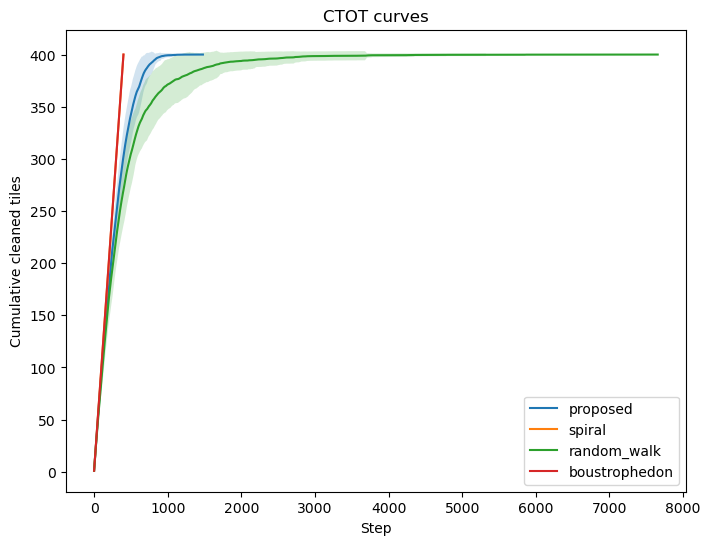

In [13]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def plot_ctot_curves(all_data_dict):
    plt.figure(figsize=(8,6))
    
    for algo, data in all_data_dict.items():
        all_cumulative = []
        max_len = 0
        
        # Compute cumulative for all episodes & find max length
        for ep in data:
            cumulative = compute_cumulative(ep)
            all_cumulative.append(cumulative)
            if len(cumulative) > max_len:
                max_len = len(cumulative)
        
        # Pad shorter sequences with their last value
        padded_cumulative = []
        for cum in all_cumulative:
            if len(cum) < max_len:
                cum = cum + [cum[-1]]*(max_len - len(cum))
            padded_cumulative.append(cum)
        
        all_cumulative = np.array(padded_cumulative)
        mean_cum = np.mean(all_cumulative, axis=0)
        std_cum = np.std(all_cumulative, axis=0)
        
        steps = np.arange(max_len)
        plt.plot(steps, mean_cum, label=algo)
        plt.fill_between(steps, mean_cum-std_cum, mean_cum+std_cum, alpha=0.2)
    
    plt.xlabel("Step")
    plt.ylabel("Cumulative cleaned tiles")
    plt.title("CTOT curves")
    plt.legend()
    plt.show()


# Example usage
all_data_dict = {
    "proposed": load_jsonl("json/episodes_proposed.jsonl"),
    "spiral": load_jsonl("json/episodes_spiral.jsonl"),
    "random_walk": load_jsonl("json/episodes_random_walk.jsonl"),
    "boustrophedon": load_jsonl("json/episodes_boustrophedon.jsonl")
}

plot_ctot_curves(all_data_dict)


     episode      algorithm    CTOT_avg  CTOT_max     AUC
0          1       proposed  134.875000       251  166548
1          2       proposed  222.392857       557  168922
2          3       proposed   44.000000       462  225860
3          4       proposed  235.600000       384  165986
4          5       proposed  218.666667       395  183546
..       ...            ...         ...       ...     ...
395       96  boustrophedon  288.000000       400   80200
396       97  boustrophedon  212.117647       385   80200
397       98  boustrophedon  282.645570       400   80200
398       99  boustrophedon  210.500000       220   80200
399      100  boustrophedon  202.333333       390   80200

[400 rows x 5 columns]
['proposed' 'spiral' 'random_walk' 'boustrophedon']


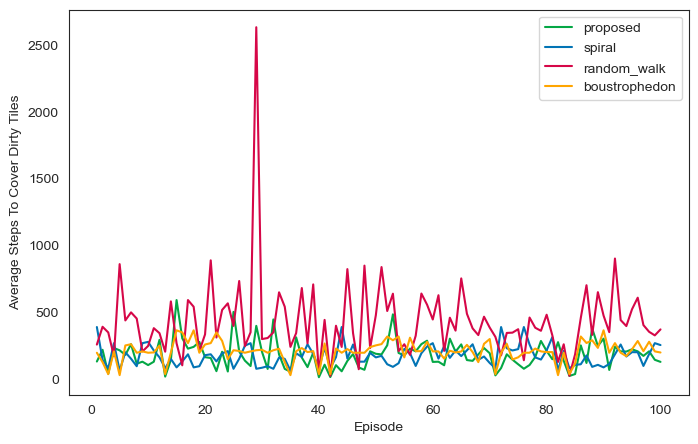

In [38]:
import matplotlib.pyplot as plt

# all_df contains columns: ["episode","algorithm","CTOT_avg","CTOT_max","AUC"]
plt.figure(figsize=(8,5))
print(all_df)
algorithms = all_df['algorithm'].unique()
colors = {
    "proposed": "#04A745",
    "spiral": "#0274B5",
    "boustrophedon": "Orange",
    "random_walk": "#D60748"
}
print(algorithms)
for algo in algorithms:
    df_algo = all_df[all_df['algorithm'] == algo]
    plt.plot(df_algo['episode'], df_algo['CTOT_avg'], label=algo, color=colors[algo])

plt.xlabel("Episode")
plt.ylabel("Average Steps To Cover Dirty Tiles")
# plt.title("Average Steps To Cover Dirty Tiles per Episode")
plt.legend()
# plt.show()
plt.savefig("coverage-dirty-tiles-steps-average-dynamic.png", dpi=600)


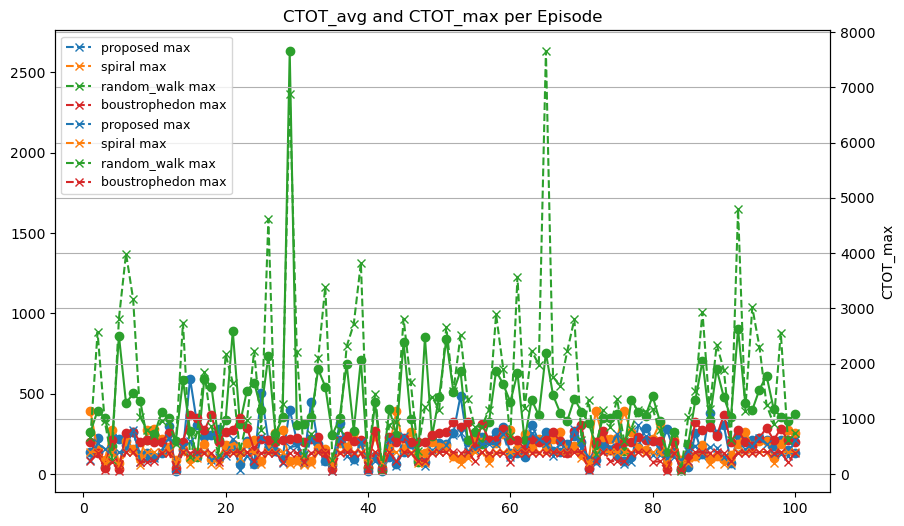

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.set_style("white")  # Removes grid

# Optionally, you can plot a rolling mean to smooth
all_df_sorted = all_df.sort_values("episode")

# Lineplot with markers removed for clarity
sns.lineplot(
    data=all_df_sorted, 
    x="episode", 
    y="Average Steps To Cover Dirty Tiles", 
    hue="algorithm", 
    markers=False,      # no markers
    # ci="sd",            # shaded std dev
    dashes=True,        # dashed lines for variety
    linewidth=2,
    alpha=0.8           # slightly transparent
)

plt.title("Average Steps To Cover Dirty Tiles per Episode")
plt.xlabel("Episode")
plt.ylabel("CTOT_avg")
plt.legend(title="Algorithm")
plt.grid(False)  # Remove background grid
plt.show()


ValueError: Could not interpret value `Average Steps To Cover Dirty Tiles` for `y`. An entry with this name does not appear in `data`.

<Figure size 1200x600 with 0 Axes>

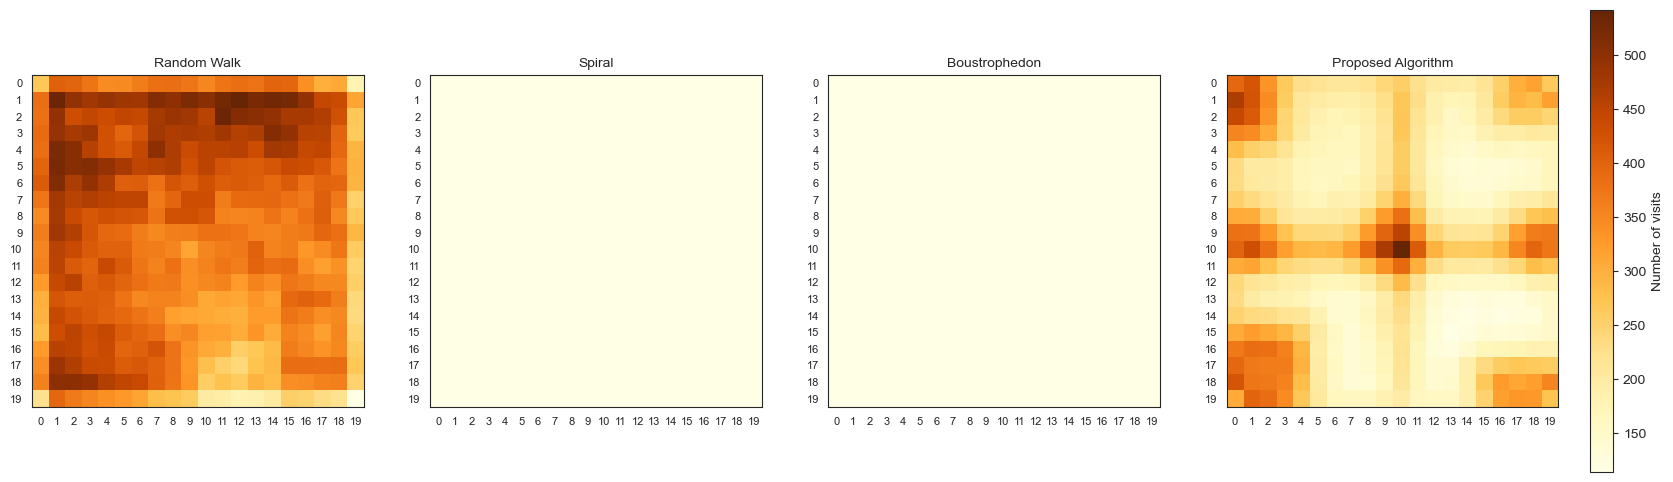

In [29]:
algorithms = {
    "Random Walk": random_walk,
    "Spiral": spiral,
    "Boustrophedon": boustrophedon,
    "Proposed Algorithm": proposed
}

fig, axes = plt.subplots(1, 4, figsize=(20, 6))  # wider figure
axes = axes.flatten()

for ax, (name, episodes) in zip(axes, algorithms.items()):
    total_visits = np.zeros((20, 20))
    for ep in episodes:
        total_visits += np.array(ep['visited'])
    
    im = ax.imshow(total_visits, cmap='YlOrBr', origin='upper')
    ax.set_title(name, fontsize=10)
    ax.set_xticks(range(20))
    ax.set_yticks(range(20))
    ax.tick_params(axis='both', labelsize=8)  # smaller tick labels

# adjust subplot spacing to make room for colorbar
plt.subplots_adjust(right=0.92)

# Shared colorbar on the right
cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_label('Number of visits', fontsize=10)

# plt.show()
plt.savefig("coverage-dirty-tiles-dynamic-heatmap.png", dpi=600)
